In [1]:
# ex70 Generating Features through Word Vector Summation
import gensim
model_path = 'GoogleNews-vectors-negative300.bin/GoogleNews-vectors-negative300.bin'
model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)


In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))


In [3]:
data_df = pd.read_csv('newsCorpora.csv', sep='\t', header=None)
data_df.drop(data_df.columns[0], axis=1, inplace=True)
rows = list(range(len(data_df.index)))
random.shuffle(rows)
data_df = data_df.iloc[rows]
data_df = data_df.reset_index(drop=True)
data_df.head()


,1,2,3,4,5,6,7
0,How to change your eBay password: reset your p...,http://www.pcadvisor.co.uk/how-to/security/352...,PC Advisor,t,dR8KtQ_sdlnCHbMcbG5eCMzpDFPSM,www.pcadvisor.co.uk,1400759267641
1,Crafts retailer Michaels raises $473 mln in IPO,http://money.msn.com/business-news/article.asp...,MSN Money,b,dq6woeC_K7MdAWMDnlFDU_Rjk6KaM,money.msn.com,1403851973928
2,Microsoft Ends Support For Windows XP With Fin...,http://www.techweekeurope.co.uk/news/windows-x...,TechWeekEurope UK,t,dI4n0Nno6NFSZUM7MU77tPw1SXRfM,www.techweekeurope.co.uk,1396992636097
3,Anna Kendrick Raps To Iggy Azalea On 'SNL': Watch,http://www.idolator.com/7513000/snl-the-little...,Idolator\: All About The Music,e,dUkT9vYJUD0kiZMZY6g65RXJ6R2FM,www.idolator.com,1396882956255
4,Study: Emperor penguin population to slide due...,http://www.theglobeandmail.com/news/world/stud...,The Globe and Mail,t,dZx6m1MtUT29FcMyc8d7SdNzC8_wM,www.theglobeandmail.com,1404152226968


In [4]:
data_df.iloc[:, 3] = data_df.iloc[:, 3].astype('category')
data_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422419 entries, 0 to 422418
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   1       422419 non-null  object  
 1   2       422419 non-null  object  
 2   3       422417 non-null  object  
 3   4       422419 non-null  category
 4   5       422419 non-null  object  
 5   6       422419 non-null  object  
 6   7       422419 non-null  int64   
dtypes: category(1), int64(1), object(5)
memory usage: 19.7+ MB


In [5]:
def data_processing(text):
    text = text.lower()
    text_tokens = word_tokenize(text)
    filtered_text = [word for word in text_tokens if word not in stop_words]
    stemmer = PorterStemmer()
    stemmed_text = [stemmer.stem(word) for word in filtered_text]
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in stemmed_text]
    return " ".join(lemmatized_text)


In [6]:
data_df.iloc[:, 0] = data_df.iloc[:, 0].apply(data_processing)

In [7]:

data = pd.DataFrame()
data['title'] = data_df.iloc[:, 0]
data['category'] = data_df.iloc[:, 3]
data.category.replace({'b': 0, 't': 1, 'e': 2, 'm': 3}, inplace=True)
data['word_count'] = data['title'].apply(lambda x: len(str(x).split(" ")))
data.shape


(422419, 3)

In [8]:
duplicate_count = data.duplicated().sum()
data = data.drop_duplicates('title')
data.shape
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 400350 entries, 0 to 422418
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   title       400350 non-null  object  
 1   category    400350 non-null  category
 2   word_count  400350 non-null  int64   
dtypes: category(1), int64(1), object(1)
memory usage: 9.5+ MB


In [9]:
X = np.zeros((len(data.index), 300))
Y = np.zeros((len(data.index), 1))
for i in range(len(data.index)):
    title = data.iloc[i, 0]
    words = title.split(" ")
    for word in words:
        if word in model:
            X[i] += model[word]
    Y[i] = data.iloc[i, 1]
print(Y.shape)

(400350, 1)


In [10]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories='auto')
Y = encoder.fit_transform(Y.reshape(-1, 1)).toarray()
print(X.shape)
print(Y.shape)

(400350, 300)
(400350, 4)


In [11]:
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)


# ex71 Building Single Layer Neural Network

In [12]:

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))
W = np.random.randn(300, 4)
y1 = softmax(np.dot(x_train[0], W))
Y_ = softmax(x_train[:4].dot(W))
print(y1)
print(Y_)

[7.90335530e-01 1.41026838e-06 2.09660588e-01 2.47197688e-06]
[[5.64868175e-02 1.00794624e-07 1.49848500e-02 1.76676995e-07]
 [4.32651972e-02 3.30500400e-03 2.77388292e-02 8.23355589e-04]
 [4.86112034e-02 3.60528614e-13 6.36783249e-01 7.57451065e-09]
 [6.17937471e-06 1.29168133e-02 1.55054966e-01 2.32501051e-05]]


# ex72 Calculating loss and gradients

In [13]:

#calculate the probability of each category
y_hat_1 = softmax(np.dot(x_train[0], W))
y_hat = softmax(x_train[:4].dot(W))
#calculate the cross entropy loss
# li=−log[probability that sample xi is classified as yi]
loss_1 = -np.log((y_hat_1).dot(y_train[0]))
loss = -np.mean(np.sum(y_train[:4] * np.log(y_hat), axis=1))
#calculate the gradients
dW1=np.outer(x_train[0],y_hat_1)
dW = np.dot(x_train[:4].T, y_hat - y_train[:4])
print(loss_1)
print(loss)
print(dW1)
print(dW)




0.23529770228467506
11.976617888773287
[[-3.69697968e-01 -6.59686087e-07 -9.80736539e-02 -1.15632512e-06]
 [ 2.73607369e-01  4.88222793e-07  7.25826937e-02  8.55777151e-07]
 [ 4.58456352e-01  8.18065837e-07  1.21619521e-01  1.43393971e-06]
 ...
 [ 2.79974818e-01  4.99584819e-07  7.42718538e-02  8.75692980e-07]
 [ 2.99270119e-01  5.34015199e-07  7.93905204e-02  9.36043978e-07]
 [ 2.08389251e-01  3.71848108e-07  5.52816003e-02  6.51790778e-07]]
[[ 0.49454089 -1.08987941  0.7126693  -0.01199485]
 [-0.30067288 -0.57743022  0.19057002 -0.72070649]
 [-0.54507016 -0.04722064  0.04292641 -0.11804916]
 ...
 [-0.3281395  -0.1161595   0.11562685  0.18520813]
 [-0.38085642  0.4553297  -0.45538224  0.01634152]
 [-0.28179026  0.65796117 -0.51749146 -0.20049544]]


## ex73. Learning with stochastic gradient descent

In [14]:
W = np.random.randn(300, 4)
W.max()

3.177969835393046

In [15]:
learning_rate = 0.01
num_epochs = 100
for epoch in range(num_epochs):
    #Shuffle training data
    indices = np.random.permutation(x_train.shape[0])
    x_train = x_train[indices]
    y_train = y_train[indices]
    
    #iterate over training set
    for i in range(x_train.shape[0]):
        #calculate the probability of each category
        y_hat = softmax(np.dot(x_train[i], W))
        #calculate the cross entropy loss
        loss = -np.log((y_hat).dot(y_train[i]))
        #calculate the gradients
        dW = np.outer(x_train[i], y_hat - y_train[i])
        #update the parameters
        W = W - learning_rate * dW
    
    

In [16]:
W

array([[-0.81604972, -0.68529429, -0.70263256, -0.7084503 ],
       [-0.33537016, -0.2625278 ,  0.00609271, -0.47723396],
       [ 0.15838749,  0.53823929,  0.22105892,  0.57908957],
       ...,
       [ 0.47439217,  0.43720439,  0.14207118,  0.45631109],
       [ 0.54166941,  0.6005626 ,  0.72537432,  0.4875002 ],
       [-0.93499931, -0.70817409, -0.48378124, -0.29241939]])

# 74. Measuring accuracy

In [17]:
y_train_pred = np.argmax(x_train.dot(W), axis=1)
accuracy_train = np.mean(y_train_pred == np.argmax(y_train, axis=1))
print("Training accuracy: ", accuracy_train)
y_eval_pred = np.argmax(x_val.dot(W), axis=1)
accuracy_eval = np.mean(y_eval_pred == np.argmax(y_val, axis=1))
print("Validation accuracy: ", accuracy_eval)

Training accuracy:  0.7954289996253279
Validation accuracy:  0.7958286499313101


# 75. Plotting loss and accuracy

Epoch: 0, Train loss: 72.8036, Train acc: 0.1658, Eval loss: 82.5762, Eval acc: 0.1651
Epoch: 1, Train loss: 67.9094, Train acc: 0.5676, Eval loss: 7.9035, Eval acc: 0.5683
Epoch: 2, Train loss: 34.3908, Train acc: 0.5945, Eval loss: 5.7834, Eval acc: 0.5951
Epoch: 3, Train loss: 24.3243, Train acc: 0.5938, Eval loss: 5.6004, Eval acc: 0.5935
Epoch: 4, Train loss: 15.8774, Train acc: 0.5950, Eval loss: 5.5376, Eval acc: 0.5944
Epoch: 5, Train loss: 13.0709, Train acc: 0.5945, Eval loss: 5.3584, Eval acc: 0.5944
Epoch: 6, Train loss: 12.4444, Train acc: 0.5958, Eval loss: 5.2565, Eval acc: 0.5959
Epoch: 7, Train loss: 11.9594, Train acc: 0.5940, Eval loss: 5.3531, Eval acc: 0.5943
Epoch: 8, Train loss: 9.1390, Train acc: 0.5896, Eval loss: 5.3822, Eval acc: 0.5893
Epoch: 9, Train loss: 14.6703, Train acc: 0.5972, Eval loss: 5.3231, Eval acc: 0.5974
Epoch: 10, Train loss: 8.1325, Train acc: 0.5934, Eval loss: 5.3108, Eval acc: 0.5928
Epoch: 11, Train loss: 8.7894, Train acc: 0.5874, Eval

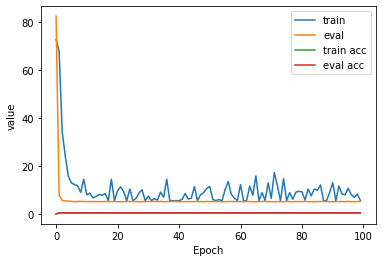

In [39]:
W2 = np.random.randn(300, 4)
eta = 0.001
n_epochs = 100
train_loss = []
eval_loss = []
train_acc = []
eval_acc = []
for epoch in range(n_epochs):
    indices = np.random.permutation(x_train.shape[0])
    x_train = x_train[indices]
    y_train = y_train[indices]
    # compute loss and accuracy on training set
    train_probs = softmax(x_train.dot(W2))
    mask = train_probs > 0
    train_probs = np.where(mask, train_probs, 1e-9)
    train_loss.append(-np.mean(y_train * np.log(train_probs)))
    train_pred = np.argmax(train_probs, axis=1)
    mask = train_pred > 0
    train_pred = np.where(mask, train_pred, 1e-9)
    train_acc.append(np.mean(train_pred == np.argmax(y_train, axis=1)))
    # compute loss and accuracy on validation set
    eval_probs = softmax(x_val.dot(W2))
    mask = eval_probs > 0
    eval_probs = np.where(mask, eval_probs, 1e-9)
    eval_loss.append(-np.mean(y_val * np.log(eval_probs)))
    eval_pred = np.argmax(eval_probs, axis=1)
    mask = eval_pred > 0
    eval_pred = np.where(mask, eval_pred, 1e-9)
    eval_acc.append(np.mean(eval_pred == np.argmax(y_val, axis=1)))
    #update the parameters
    for i in range(x_train.shape[0]):
        y_hat = softmax(np.dot(x_train[i], W2))
        loss = -np.log((y_hat).dot(y_train[i]))
        dW = np.outer(x_train[i], y_hat - y_train[i])
        W2 = W2 - eta * dW
    #print progress
    print("Epoch: %d, Train loss: %.4f, Train acc: %.4f, Eval loss: %.4f, Eval acc: %.4f" % (epoch, train_loss[-1], train_acc[-1], eval_loss[-1], eval_acc[-1]))
    
plt.plot(train_loss, label='train')
plt.plot(eval_loss, label='eval')
plt.plot(train_acc, label='train acc')
plt.plot(eval_acc, label='eval acc')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('value')
plt.show()


# 76. Checkpoints

Epoch: 0, Train loss: 207128378.1852, Train acc: 0.2271, Eval loss: 20452132.1188, Eval acc: 0.2301
Epoch: 1, Train loss: 143724681.5858, Train acc: 0.7653, Eval loss: 11942489.4002, Eval acc: 0.7646
Epoch: 2, Train loss: 108683604.6328, Train acc: 0.7951, Eval loss: 7637063.4229, Eval acc: 0.7943
Epoch: 3, Train loss: 108227754.9302, Train acc: 0.8039, Eval loss: 6616813.1647, Eval acc: 0.8032
Epoch: 4, Train loss: 104647177.6811, Train acc: 0.8056, Eval loss: 6464926.1432, Eval acc: 0.8046
Epoch: 5, Train loss: 102107663.7096, Train acc: 0.8073, Eval loss: 6152051.4501, Eval acc: 0.8058
Epoch: 6, Train loss: 106035254.8185, Train acc: 0.8063, Eval loss: 6303539.7090, Eval acc: 0.8046
Epoch: 7, Train loss: 106518402.5371, Train acc: 0.8064, Eval loss: 5679543.4387, Eval acc: 0.8039
Epoch: 8, Train loss: 103984185.8772, Train acc: 0.8072, Eval loss: 5866733.4004, Eval acc: 0.8050
Epoch: 9, Train loss: 101739776.1591, Train acc: 0.8076, Eval loss: 5532978.2845, Eval acc: 0.8045
Epoch: 1

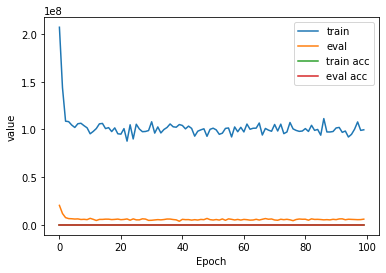

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))


def cross_entropy_loss(y_true, y_pred):
    mask = y_pred > 0
    y_pred = np.where(mask, y_pred, 1e-9)
    return -np.sum(y_true * np.log(y_pred))


# np.random.seed(42)
# x_train = np.random.randn(1000, 300)
# y_train = np.random.randint(0, 4, size=(1000,))
# y_train = np.eye(4)[y_train]
# x_val = np.random.randn(100, 300)
# y_val = np.random.randint(0, 4, size=(100,))
# y_val = np.eye(4)[y_val]

W2 = np.random.randn(300, 4)
eta = 0.001
n_epochs = 100
train_loss = []
eval_loss = []
train_acc = []
eval_acc = []

# create an empty dictionary to store checkpoints
checkpoints = {}

for epoch in range(n_epochs):
    indices = np.random.permutation(x_train.shape[0])
    x_train = x_train[indices]
    y_train = y_train[indices]
    # compute loss and accuracy on training set
    train_probs = softmax(x_train.dot(W2))
    train_loss.append(cross_entropy_loss(y_train, train_probs))
    train_pred = np.argmax(train_probs, axis=1)
    train_acc.append(np.mean(train_pred == np.argmax(y_train, axis=1)))
    # compute loss and accuracy on validation set
    eval_probs = softmax(x_val.dot(W2))
    eval_loss.append(cross_entropy_loss(y_val, eval_probs))
    eval_pred = np.argmax(eval_probs, axis=1)
    eval_acc.append(np.mean(eval_pred == np.argmax(y_val, axis=1)))
    # update the parameters
    for i in range(x_train.shape[0]):
        y_hat = softmax(np.dot(x_train[i], W2))
        dW = np.outer(x_train[i], y_hat - y_train[i])
        W2 = W2 - eta * dW
    # store the checkpoint
    checkpoints[epoch] = {'W2': W2, 'eta': eta}
    with open('checkpoints.pkl', 'wb') as f:
        pickle.dump(checkpoints, f)
    # print progress
    print("Epoch: %d, Train loss: %.4f, Train acc: %.4f, Eval loss: %.4f, Eval acc: %.4f" % (
        epoch, train_loss[-1], train_acc[-1], eval_loss[-1], eval_acc[-1]))

plt.plot(train_loss, label='train')
plt.plot(eval_loss, label='eval')
plt.plot(train_acc, label='train acc')
plt.plot(eval_acc, label='eval acc')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('value')
plt.show()


# 77. Mini-batches

Testing batch size 1...
Epoch: 0, Train loss: 102247614.8134, Train acc: 0.7691, Eval loss: 6213321.2580, Eval acc: 0.7673
Epoch: 1, Train loss: 84984088.8856, Train acc: 0.7981, Eval loss: 6486171.9928, Eval acc: 0.7965
Epoch: 2, Train loss: 78081669.7052, Train acc: 0.8042, Eval loss: 6420645.9790, Eval acc: 0.8024
Epoch: 3, Train loss: 74493172.4215, Train acc: 0.8062, Eval loss: 6224736.1230, Eval acc: 0.8043
Epoch: 4, Train loss: 74292170.3079, Train acc: 0.8067, Eval loss: 6397599.0756, Eval acc: 0.8051
Epoch: 5, Train loss: 66743733.0681, Train acc: 0.8075, Eval loss: 5842201.2155, Eval acc: 0.8063
Epoch: 6, Train loss: 75716384.8349, Train acc: 0.8075, Eval loss: 6693166.1294, Eval acc: 0.8056
Epoch: 7, Train loss: 68001205.1707, Train acc: 0.8075, Eval loss: 6227398.8458, Eval acc: 0.8056
Epoch: 8, Train loss: 67740316.0190, Train acc: 0.8073, Eval loss: 5879032.0132, Eval acc: 0.8057
Epoch: 9, Train loss: 53510867.0146, Train acc: 0.8064, Eval loss: 4738392.9797, Eval acc: 0.

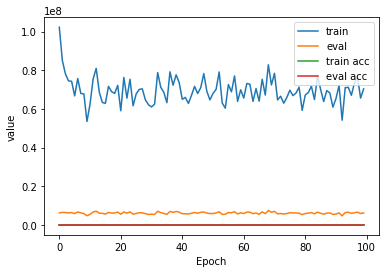

Testing batch size 2...


C:\Users\dotha\AppData\Local\Temp\ipykernel_17096\3837361428.py:6: RuntimeWarning: overflow encountered in exp
  return np.exp(x) / np.sum(np.exp(x))
C:\Users\dotha\AppData\Local\Temp\ipykernel_17096\3837361428.py:6: RuntimeWarning: invalid value encountered in divide
  return np.exp(x) / np.sum(np.exp(x))


Epoch: 0, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 1, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 2, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 3, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 4, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 5, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 6, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 7, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 8, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 9, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 10, Train loss: 6637247.5823, Tra

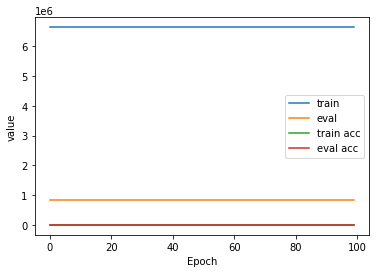

Testing batch size 4...
Epoch: 0, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 1, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 2, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 3, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 4, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 5, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 6, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 7, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 8, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 9, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 10, Train

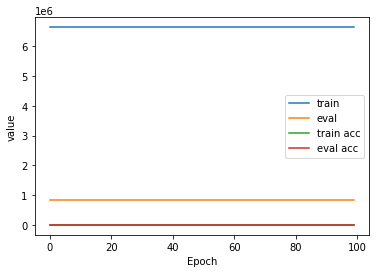

Testing batch size 8...
Epoch: 0, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 1, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 2, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 3, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 4, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 5, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 6, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 7, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 8, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 9, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 10, Train

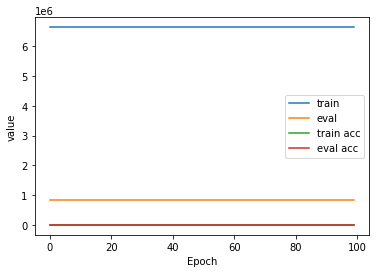

Testing batch size 16...
Epoch: 0, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 1, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 2, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 3, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 4, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 5, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 6, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 7, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 8, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 9, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 10, Trai

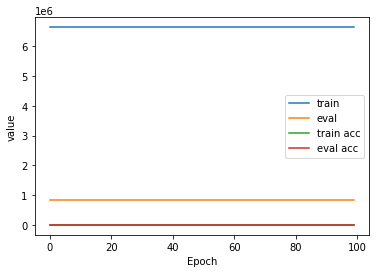

Testing batch size 32...
Epoch: 0, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 1, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 2, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 3, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 4, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 5, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 6, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 7, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 8, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 9, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 10, Trai

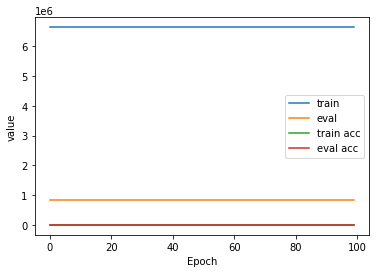

Testing batch size 64...
Epoch: 0, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 1, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 2, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 3, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 4, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 5, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 6, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 7, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 8, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 9, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 10, Trai

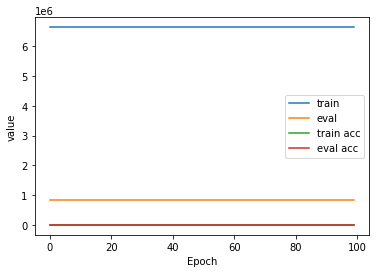

Testing batch size 128...
Epoch: 0, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 1, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 2, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 3, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 4, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 5, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 6, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 7, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 8, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 9, Train loss: 6637247.5823, Train acc: 0.2742, Eval loss: 829655.9478, Eval acc: 0.2753
Epoch: 10, Tra

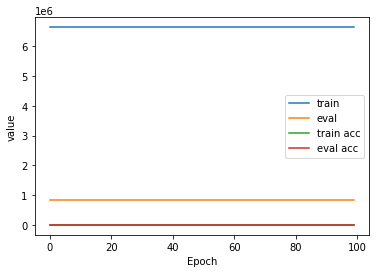

In [47]:
import time

# Define mini-batch sizes to test
batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128]

for batch_size in batch_sizes:
    print(f"Testing batch size {batch_size}...")

    # Initialize parameters and hyperparameters
    W2 = np.random.randn(300, 4)
    eta = 0.001
    n_epochs = 100
    train_loss = []
    eval_loss = []
    train_acc = []
    eval_acc = []

    start_time = time.time()

    # Loop over epochs
    for epoch in range(n_epochs):
        # Shuffle training data
        indices = np.random.permutation(x_train.shape[0])
        x_train = x_train[indices]
        y_train = y_train[indices]

        # Loop over mini-batches
        for i in range(0, x_train.shape[0], batch_size):
            # Get mini-batch
            x_batch = x_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Compute loss and gradient
            y_hat = softmax(np.dot(x_batch, W2))
            loss = cross_entropy_loss(y_batch, y_hat)
            # loss = -np.mean(y_batch * np.log(y_hat))
            dW = np.dot(x_batch.T, y_hat - y_batch)

            # Update weights
            W2 -= eta * dW

        # Compute loss and accuracy on training set
        train_probs = softmax(x_train.dot(W2))
        train_loss.append(cross_entropy_loss(y_train, train_probs))
        # train_loss.append(-np.mean(y_train * np.log(train_probs)))
        train_pred = np.argmax(train_probs, axis=1)
    
        train_acc.append(np.mean(train_pred == np.argmax(y_train, axis=1)))

        # Compute loss and accuracy on validation set
        eval_probs = softmax(x_val.dot(W2))
        eval_loss.append(cross_entropy_loss(y_val, eval_probs))
        # eval_loss.append(-np.mean(y_val * np.log(eval_probs)))
        eval_pred = np.argmax(eval_probs, axis=1)
        eval_acc.append(np.mean(eval_pred == np.argmax(y_val, axis=1)))

        # Print progress
        print("Epoch: %d, Train loss: %.4f, Train acc: %.4f, Eval loss: %.4f, Eval acc: %.4f" % (
            epoch, train_loss[-1], train_acc[-1], eval_loss[-1], eval_acc[-1]))

    end_time = time.time()
    print(
        f"Training with batch size {batch_size} took {end_time - start_time:.2f} seconds")

    # Plot loss and accuracy
    plt.plot(train_loss, label='train')
    plt.plot(eval_loss, label='eval')
    plt.plot(train_acc, label='train acc')
    plt.plot(eval_acc, label='eval acc')

    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('value')
    plt.show()


# 78. Training on a GPU

In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

# Define neural network architecture


class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(300, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Define mini-batch sizes to test
batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128]

# Move data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert data to PyTorch tensors
x_train = torch.Tensor(x_train).to(device)
y_train = torch.Tensor(y_train).to(device)
x_val = torch.Tensor(x_val).to(device)
y_val = torch.Tensor(y_val).to(device)

for batch_size in batch_sizes:
    print(f"Testing batch size {batch_size}...")

    # Initialize model, loss function, and optimizer
    model = MyModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001)

    start_time = time.time()

    # Loop over epochs
    for epoch in range(100):
        # Shuffle training data
        indices = torch.randperm(x_train.shape[0])
        x_train = x_train[indices]
        y_train = y_train[indices]

        # Loop over mini-batches
        for i in range(0, x_train.shape[0], batch_size):
            # Get mini-batch
            x_batch = x_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            y_hat = model(x_batch)
            loss = criterion(y_hat, torch.argmax(y_batch, dim=1))

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Compute loss and accuracy on training set
        with torch.no_grad():
            train_probs = model(x_train)
            train_loss = criterion(train_probs, torch.argmax(y_train, dim=1))
            train_pred = torch.argmax(train_probs, dim=1)
            train_acc = torch.mean(
                (train_pred == torch.argmax(y_train, dim=1)).float())

            # Compute loss and accuracy on validation set
            eval_probs = model(x_val)
            eval_loss = criterion(eval_probs, torch.argmax(y_val, dim=1))
            eval_pred = torch.argmax(eval_probs, dim=1)
            eval_acc = torch.mean(
                (eval_pred == torch.argmax(y_val, dim=1)).float())

            # Print progress
            print(
                f"Epoch: {epoch}, Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Eval loss: {eval_loss:.4f}, Eval acc: {eval_acc:.4f}")

    end_time = time.time()
    print(
        f"Training with batch size {batch_size} took {end_time - start_time:.2f} seconds")


Testing batch size 1...
Epoch: 0, Train loss: 0.4029, Train acc: 0.8543, Eval loss: 0.4161, Eval acc: 0.8493
Epoch: 1, Train loss: 0.3412, Train acc: 0.8771, Eval loss: 0.3718, Eval acc: 0.8654
Epoch: 2, Train loss: 0.3062, Train acc: 0.8910, Eval loss: 0.3494, Eval acc: 0.8746
Epoch: 3, Train loss: 0.2766, Train acc: 0.9018, Eval loss: 0.3301, Eval acc: 0.8813
Epoch: 4, Train loss: 0.2646, Train acc: 0.9056, Eval loss: 0.3265, Eval acc: 0.8847
Epoch: 5, Train loss: 0.2544, Train acc: 0.9095, Eval loss: 0.3259, Eval acc: 0.8848
Epoch: 6, Train loss: 0.2403, Train acc: 0.9151, Eval loss: 0.3218, Eval acc: 0.8875
Epoch: 7, Train loss: 0.2298, Train acc: 0.9182, Eval loss: 0.3194, Eval acc: 0.8887
Epoch: 8, Train loss: 0.2259, Train acc: 0.9206, Eval loss: 0.3248, Eval acc: 0.8870
Epoch: 9, Train loss: 0.2184, Train acc: 0.9233, Eval loss: 0.3230, Eval acc: 0.8878
Epoch: 10, Train loss: 0.2117, Train acc: 0.9255, Eval loss: 0.3220, Eval acc: 0.8899
Epoch: 11, Train loss: 0.2096, Train acc

KeyboardInterrupt: 

In [73]:
import time
import torch

# Define mini-batch sizes to test
batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128]

# Convert numpy arrays to PyTorch tensors
x_train_tensor = torch.Tensor(x_train)
y_train_tensor = torch.Tensor(y_train)
x_val_tensor = torch.Tensor(x_val)
y_val_tensor = torch.Tensor(y_val)

# Define neural network architecture
model = torch.nn.Sequential(
    torch.nn.Linear(300, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 4)
)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

for batch_size in batch_sizes:
    print(f"Testing batch size {batch_size}...")

    # Initialize lists to store loss and accuracy values
    train_loss = []
    eval_loss = []
    train_acc = []
    eval_acc = []

    start_time = time.time()

    # Loop over epochs
    for epoch in range(100):
        # Shuffle training data
        indices = torch.randperm(x_train_tensor.shape[0])
        x_train_tensor = x_train_tensor[indices]
        y_train_tensor = y_train_tensor[indices]

        # Loop over mini-batches
        for i in range(0, x_train_tensor.shape[0], batch_size):
            # Get mini-batch
            x_batch = x_train_tensor[i:i+batch_size]
            y_batch = y_train_tensor[i:i+batch_size]

            # Zero out gradients
            optimizer.zero_grad()

            # Forward pass
            y_hat = model(x_batch)

            # Compute loss
            loss = criterion(y_hat, y_batch)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

        # Compute loss and accuracy on training set
        train_probs = torch.nn.functional.softmax(model(x_train_tensor), dim=1)
        train_loss.append(criterion(train_probs, y_train_tensor).item())
        train_pred = torch.argmax(train_probs, axis=1)
        train_acc.append(torch.mean((train_pred == torch.argmax(y_train_tensor, dim=1)).float()))

        # Compute loss and accuracy on validation set
        eval_probs = torch.nn.functional.softmax(model(x_val_tensor), dim=1)
        eval_loss.append(criterion(eval_probs, y_val_tensor).item())
        eval_pred = torch.argmax(eval_probs, axis=1)
        eval_acc.append(torch.mean((eval_pred == torch.argmax(y_val_tensor, dim=1)).float()))

        # Print progress
        print("Epoch: %d, Train loss: %.4f, Train acc: %.4f, Eval loss: %.4f, Eval acc: %.4f" % (
            epoch, train_loss[-1], train_acc[-1], eval_loss[-1], eval_acc[-1]))

    end_time = time.time()
    print(
        f"Training with batch size {batch_size} took {end_time - start_time:.2f} seconds")

    # Plot loss and accuracy
    plt.plot(train_loss, label='train')
    plt.plot(eval_loss, label='eval')
    plt.plot(train_acc, label='train acc')
    plt.plot(eval_acc, label='eval acc')

    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('value')
    plt.show()

Testing batch size 1...
Epoch: 0, Train loss: 0.9543, Train acc: 0.8313, Eval loss: 0.9557, Eval acc: 0.8305
Epoch: 1, Train loss: 0.9321, Train acc: 0.8488, Eval loss: 0.9351, Eval acc: 0.8456
Epoch: 2, Train loss: 0.9118, Train acc: 0.8714, Eval loss: 0.9179, Eval acc: 0.8627
Epoch: 3, Train loss: 0.9034, Train acc: 0.8761, Eval loss: 0.9111, Eval acc: 0.8658
Epoch: 4, Train loss: 0.8916, Train acc: 0.8863, Eval loss: 0.9016, Eval acc: 0.8723
Epoch: 5, Train loss: 0.8877, Train acc: 0.8883, Eval loss: 0.8989, Eval acc: 0.8733
Epoch: 6, Train loss: 0.8852, Train acc: 0.8901, Eval loss: 0.8974, Eval acc: 0.8723
Epoch: 7, Train loss: 0.8805, Train acc: 0.8942, Eval loss: 0.8938, Eval acc: 0.8761
Epoch: 8, Train loss: 0.8783, Train acc: 0.8967, Eval loss: 0.8921, Eval acc: 0.8777
Epoch: 9, Train loss: 0.8740, Train acc: 0.8969, Eval loss: 0.8884, Eval acc: 0.8780
Epoch: 10, Train loss: 0.8749, Train acc: 0.8993, Eval loss: 0.8908, Eval acc: 0.8782
Epoch: 11, Train loss: 0.8714, Train acc